In [1]:
import numpy as np
# import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import itertools
import torch
from tqdm import tqdm
from scipy import stats
from matplotlib import rcParams
from linclab_utils import plot_utils
from matplotlib.ticker import MaxNLocator
import imp
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from pprint import pprint
from argparse import ArgumentParser
import itertools

from lib.dense_layers import DenseLayer, EiDense, ColumnEiDense
from lib.base_rnn import RNNCell 
from lib.model import Model
from lib.dann_rnn import EiRNNCell
from lib.song_rnn import ColumnEiCell
from lib.update_policies import EiRNN_cSGD_UpdatePolicy, DalesANN_cSGD_UpdatePolicy, ColumnEiSGD_Clip, ColumnEiDenseSGD
from lib.init_policies import EiDenseWeightInit_WexMean, U_TorchInit, W_TorchInit, ColumnEiCell_W_InitPolicy, ColumnEi_FirstCell_U_InitPolicy, EiRNNCell_U_InitPolicy, EiRNNCell_W_InitPolicy, W_UniformInit

from lib import utils
from lib import rnn_basic_tasks
from lib.utils import acc_func
from config import PLAYGROUND_DIR
# %matplotlib inline

In [2]:
lr_list = np.geomspace(5e-2, 5e-4, num=7, endpoint=True)
for lr in lr_list:
    print(round(lr, 6))

0.05
0.023208
0.010772
0.005
0.002321
0.001077
0.0005


In [3]:
def evaluate_on_test_set(model_state_dict, model_type="dann"):
    n_output_classes = 10
    input_features = 28
    batch_size = 32
    test_size = 10000
    train_dataloader, test_dataloader = rnn_basic_tasks.get_mnist_train_test_dataloaders(batch_size, test_batch_size=test_size)
    if model_type == "dann":
        cells = [EiRNNCell(input_features, n_hidden,n_hidden//10,n_hidden//10,nonlinearity=F.relu, h2h_init_policy=EiRNNCell_W_InitPolicy())]
        cells.append(EiDense(n_hidden, n_output_classes, n_output_classes//10, nonlinearity=None))   
    elif model_type == "song":
        cells = [ColumnEiCell(input_features, (n_hidden, 9),nonlinearity=F.relu),
                ColumnEiDense(n_hidden, (n_output_classes, 9), nonlinearity=None)
                ]
    else:
        cells = [RNNCell(input_features, n_hidden, nonlinearity=F.relu), 
                 DenseLayer(n_hidden, n_output_classes, nonlinearity=None)]
    model = Model(cells)
    model.load_state_dict(model_state_dict)
    n_rows = 28

    model.to(device)
    model.eval()
    test_err_buffer  = []
    test_loss_buffer = []
    for test_batch_i, (x, y) in enumerate(test_dataloader): 
        y = y.to(device)
        x = x.to(device) # of shape B=bs x C=1 x H=28, W=28 ]
        model.reset_hidden(x.shape[0])
        for row_i in range(n_rows):
            x_row = x[:, 0, row_i, :]
            yhat  = model(x_row)
        loss = F.cross_entropy(yhat,y)
        acc = acc_func(yhat, y)
        test_err_buffer.append((1 - acc)*100)
        test_loss_buffer.append(loss.item())
    return np.mean(test_err_buffer)

In [ ]:
n_output_classes = 10
input_features = 28
num=(rad/2)**2
cells = [EiRNNCell(input_features, n_hidden,n_hidden//10,n_hidden//10,nonlinearity=F.relu, h2h_init_policy=EiRNNCell_W_InitPolicy(numerator=num))]
cells.append(EiDense(n_hidden, n_output_classes, n_output_classes//10, nonlinearity=None))  
cells[-1].update_policy = DalesANN_cSGD_UpdatePolicy(max_grad_norm=max_gn)   
for cell in cells[:-1]:
    cell.update_policy = EiRNN_cSGD_UpdatePolicy(max_grad_norm=max_gn) 
model = Model(cells)
model.load_state_dict(dann_model)

In [ ]:
val_interval = 100
n_batches_to_average_for_train_performance = 10

device = utils.get_device()
utils.set_seed_all(seed)
batch_size = 32
test_size = 10000

train_dataloader, test_dataloader = rnn_basic_tasks.get_mnist_train_test_dataloaders(batch_size,
                                                                                    test_batch_size=test_size)
n_rows = 28

model.to(device)

model.eval()
test_err_buffer  = []
test_loss_buffer = []
for test_batch_i, (x, y) in enumerate(test_dataloader): 
    y = y.to(device)
    x = x.to(device) # of shape B=bs x C=1 x H=28, W=28 ]
    model.reset_hidden(x.shape[0])
    for row_i in range(n_rows):
        # x_row = utils.batch_last(x[:, 0, row_i, :])
        x_row = x[:, 0, row_i, :]
        yhat  = model(x_row)
    # loss = F.cross_entropy(yhat.T,y)
    loss = F.cross_entropy(yhat,y)
    # acc = acc_func(yhat.T, y)
    acc = acc_func(yhat, y)
    test_err_buffer.append((1 - acc)*100)
    test_loss_buffer.append(loss.item())
print(np.mean(test_err_buffer))

In [ ]:
grad_clip_list = [1, 5, 10, None]
lr_list = np.geomspace(5e-2, 5e-4, num=7, endpoint=True)
rad_list = [0.4+0.1*i for i in range(7)] + [2+i for i in range(7)] + [2/np.sqrt(3), 2*np.sqrt(2), 9, 10, 11, 12, 13]
# rad_list = [2+i for i in range(7)]
seeds = [i for i in range(5)]
para_comb = list(itertools.product(lr_list, grad_clip_list))
num_rec_cells = 1
hidden = 100
(num_rec_cells, n_hidden) = (1, 100)

dann_acc_rad = []
# dann_acc_rad_std = []
song_acc_rad = []
# song_acc_rad_std = []
rnn_acc_rad = []

dann_best_para_list = []
song_best_para_list = []
rnn_best_para_list = []

device = utils.get_device()

for ind, rad in tqdm(enumerate(rad_list)):
    
    if ind > 13: rad = round(rad, 4)
    
    dann_acc_para_dict = {}
    song_acc_para_dict = {}
    rnn_acc_para_dict = {}
    
    for (lr, GC) in para_comb:
        dann_rnn = {k: np.zeros((len(seeds),468))*np.nan for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}
        song_rnn = {k: np.zeros((len(seeds),468))*np.nan for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}
        rnn = {k: np.zeros((len(seeds),468))*np.nan for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}  
        

        for i in seeds:
            lr_s = round(lr, 6)
            # try: 
            s = np.load(f'/network/projects/linclab_users/danns/playground/seq_mnist_balanced_song_neural_comp/batch_size-32/seed-{i}/real_song_rnn_learning_curves_seed{i}_num_rec_cells{num_rec_cells}_hidden{hidden}_lr{lr_s}_GC{GC}_rad{rad}.npz')
            song_rnn["train_err"][i, :] = s["train_err"]
            song_rnn["test_err"][i, :] = s["test_err"]
            song_rnn["train_loss"][i, :] = s["train_loss"]
            song_rnn["test_loss"][i, :] = s["test_loss"]
            song_rnn["update"][i, :] = s["update"]
                
            # except: pass
            lr_d = round(lr, 6)
            # try: 
            d = np.load(f'/network/projects/linclab_users/danns/playground/seq_mnist_danns_neural_comp/batch_size-32/seed-{i}/danns_rnn_learning_curves_seed{i}_num_rec_cells{num_rec_cells}_hidden{hidden}_lr{lr_d}_GC{GC}_rad{rad}.npz')
            dann_rnn["train_err"][i, :] = d["train_err"]
            dann_rnn["test_err"][i, :] = d["test_err"]
            dann_rnn["train_loss"][i, :] = d["train_loss"]
            dann_rnn["test_loss"][i, :] = d["test_loss"]
            dann_rnn["update"][i, :] = d["update"]
            # except: pass
            lr = round(lr, 6)
            # try: 
            r = np.load(f'/network/projects/linclab_users/danns/playground/seq_mnist_rnn_neural_comp/batch_size-32/seed-{i}/rnn_learning_curves_seed{i}_num_rec_cells{num_rec_cells}_hidden{hidden}_lr{lr}_GC{GC}_rad{rad}.npz')
            rnn["train_err"][i, :] = r["train_err"]
            rnn["test_err"][i, :] = r["test_err"]
            rnn["train_loss"][i, :] = r["train_loss"]
            rnn["test_loss"][i, :] = r["test_loss"]
            rnn["update"][i, :] = r["update"]
        song_acc_para_dict.update({np.nanmean(song_rnn["test_err"], axis=0)[-1] : (lr, GC, np.nanstd(song_rnn["test_err"], axis=0)[-1]) })
        dann_acc_para_dict.update({np.nanmean(dann_rnn["test_err"], axis=0)[-1] : (lr, GC, np.nanstd(dann_rnn["test_err"], axis=0)[-1]) })
        rnn_acc_para_dict.update({np.nanmean(rnn["test_err"], axis=0)[-1] : (lr, GC, np.nanstd(rnn["test_err"], axis=0)[-1]) })

        
    dann_best_para_list.append( dann_acc_para_dict.get(np.nanmin(list(dann_acc_para_dict.keys()))) )
    song_best_para_list.append( song_acc_para_dict.get(np.nanmin(list(song_acc_para_dict.keys()))) )
    rnn_best_para_list.append( rnn_acc_para_dict.get(np.nanmin(list(rnn_acc_para_dict.keys()))) )
    dann_rnn = {k: np.zeros((len(seeds)))*np.nan for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}
    song_rnn = {k: np.zeros((len(seeds)))*np.nan for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}
    rnn = {k: np.zeros((len(seeds)))*np.nan for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}
    
    for i in seeds:
        (lr, GC, _) = song_best_para_list[ind]
        lr_s = round(lr, 6)

        song_model = torch.load(f'/network/projects/linclab_users/danns/playground/saved_models/seq_mnist_balanced_real_song_seed{i}_num_rec_cells{num_rec_cells}_hidden{hidden}_lr{lr_s}_GC{GC}_rad{rad}.pth')

        
        (lr, GC, _) = dann_best_para_list[ind]
        lr_d = round(lr, 6)
        
        dann_model = torch.load(f'/network/projects/linclab_users/danns/playground/saved_models/danns_model_seed{i}_num_rec_cells{num_rec_cells}_hidden{hidden}_lr{lr_d}_GC{GC}_rad{rad}.pth')
        
        
        (lr, GC, _) = rnn_best_para_list[ind]
        lr = round(lr, 6)
        
        rnn_model = torch.load(f'/network/projects/linclab_users/danns/playground/saved_models/rnn_model_seed{i}_num_rec_cells{num_rec_cells}_hidden{hidden}_lr{lr}_GC{GC}_rad{rad}.pth')
        
        song_rnn["test_err"][i] = evaluate_on_test_set(song_model, model_type="song")
        dann_rnn["test_err"][i] = evaluate_on_test_set(dann_model, model_type="dann")
        rnn["test_err"][i] = evaluate_on_test_set(rnn_model, model_type="rnn")

        
    song_acc_rad.append(song_rnn["test_err"])
    dann_acc_rad.append(dann_rnn["test_err"])
    rnn_acc_rad.append(rnn["test_err"])

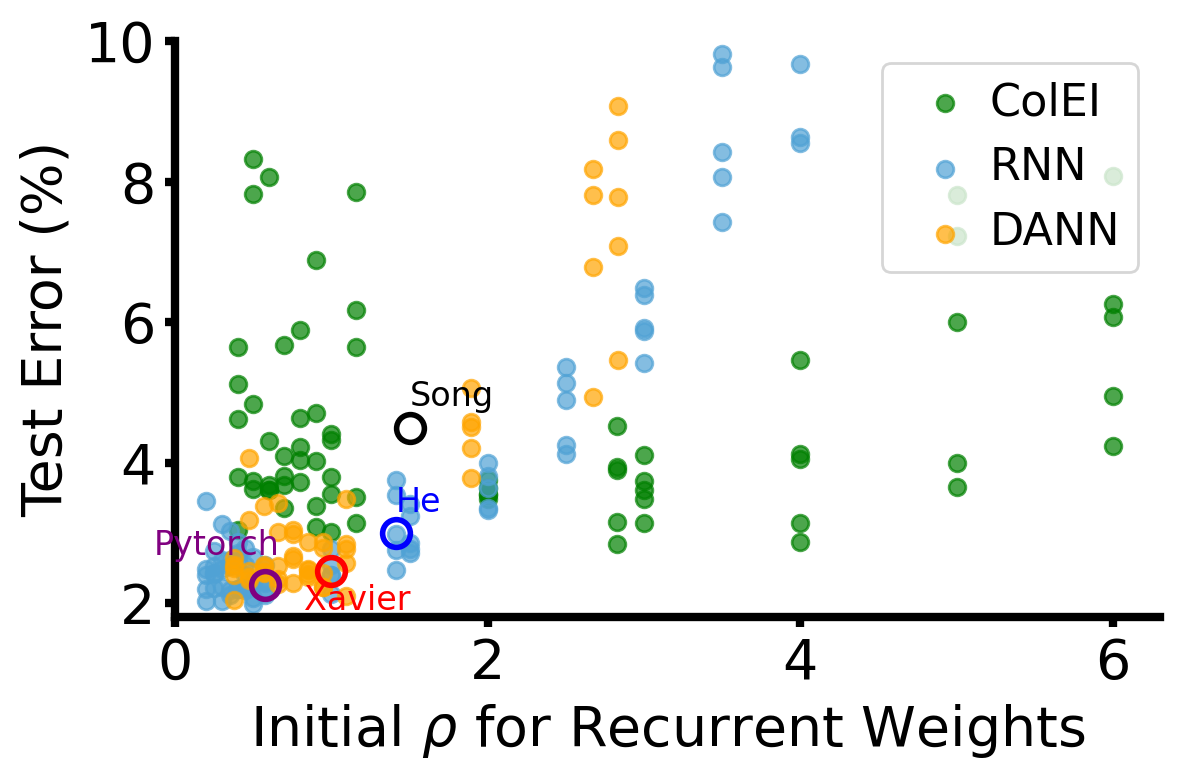

In [20]:
ax = plt.subplot(111)
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams["figure.figsize"] = (6,4)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_linewidth(3)
ax.spines.bottom.set_linewidth(3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)


rad_list_x = np.array(rad_list).repeat(5).reshape(-1)

ax.scatter(x=np.sort(rad_list_x), y=np.array(song_acc_rad).reshape(-1)[np.argsort(rad_list_x)], color='green', alpha=0.7)
# ax.scatter(x=(np.sort(rad_list_x)/2), y=(np.array(rnn_acc_rad).reshape(-1)[np.argsort(rad_list_x)]), color='#50a2d5', alpha=0.7)
ax.scatter(x=(np.sort(rad_list_x)/2), y=(np.array(rnn_acc_rad).reshape(-1)[np.argsort(rad_list_x)]), color='#50a2d5', alpha=0.7)
# ax.scatter(x=np.sort(rad_list_x_rnn)/2, y=(rnn_acc_rad_y)[np.argsort(rad_list_x_rnn)], color='#50a2d5', alpha=0.7)
ax.scatter(x=np.sort(rad_list_x)/2, y=np.array(dann_acc_rad).reshape(-1)[np.argsort(rad_list_x)], color='orange', alpha=0.7)


ax.set_xlabel(r'Initial $\rho$ for Recurrent Weights', fontsize=20)
ax.set_ylabel('Test Error (%)', fontsize=20)

# plt.legend(["Song RNN", "RNN"], fontsize=16, frameon=True, loc='upper right', handletextpad=0.01)
plt.legend(["ColEI", "RNN", "DANN"], fontsize=16, frameon=True, loc='upper right', handletextpad=0.01)
# plt.legend(["ColEI", "RNN"], fontsize=16, frameon=True, loc='upper right', handletextpad=0.01)

ax.plot(1/np.sqrt(3), 2.264, 'o', ms=10, mec='purple', mfc='none', mew=2)
ax.annotate('Pytorch', xy=(1/np.sqrt(3), 2.414), xytext=(-40, 7), textcoords='offset points', color='purple', fontsize=12)

ax.plot(1, 2.454, 'o', ms=10, mec='r', mfc='none', mew=2)
ax.annotate('Xavier', xy=(1, 2.458), xytext=(-10, -14), textcoords='offset points', color='red', fontsize=12)

ax.plot(1*np.sqrt(2), 3.006, 'o', ms=10, mec='blue', mfc='none', mew=2)
ax.annotate('He', xy=(1*np.sqrt(2), 2.904), xytext=(0, 10), textcoords='offset points', color='blue', fontsize=12)

ax.plot(1.5, 4.496, 'o', ms=10, mec='k', mfc='none', mew=2)
ax.annotate('Song', xy=(1.5, 4.496), xytext=(0, 8), textcoords='offset points', color='k', fontsize=12)

# ax.plot(1.5, 3.326, 'o', ms=10, mec='k', mfc='none', mew=2)
# ax.annotate('Song', xy=(1.5, 3.326), xytext=(0, 8), textcoords='offset points', color='k', fontsize=12)

ax.set_yticks([2, 10])
ax.set_ylim([1.8, 10])
ax.set_xlim([0, 6.3])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.yaxis.set_major_locator(MaxNLocator(5)) 

plt.tight_layout()

# plt.savefig('exps/neural_comp/new_plots/Song_RNN_Eigen_Sweep_Test_Corrected.png', format='png', dpi=200)
# plt.savefig('exps/neural_comp/new_plots/Song_RNN_Eigen_Sweep_Test_Corrected.svg', format='svg', dpi=200)
# plt.savefig('exps/neural_comp/new_plots/Song_RNN_Eigen_Sweep_Test_Corrected_remove.png', format='png', dpi=200)
# plt.savefig('exps/neural_comp/new_plots/Song_RNN_Eigen_Sweep_Test_Corrected_remove.svg', format='svg', dpi=200)
plt.savefig('exps/neural_comp/new_plots/Song_RNN_DANN_Eigen_Sweep_Test_Corrected.png', format='png', dpi=200)
plt.savefig('exps/neural_comp/new_plots/Song_RNN_DANN_Eigen_Sweep_Test_Corrected.svg', format='svg', dpi=200)
# plt.savefig('exps/neural_comp/new_plots/Song_RNN_DANN_Eigen_Sweep_Test_Corrected_remove.png', format='png', dpi=200)
# plt.savefig('exps/neural_comp/new_plots/Song_RNN_DANN_Eigen_Sweep_Test_Corrected_remove.svg', format='svg', dpi=200)


plt.show()